# Load

## Libraries

In [1]:
%matplotlib notebook

In [31]:
import numpy as np
import itertools as it
import sklearn as skl
from sklearn import datasets

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Utilities

In [4]:
def labelXYZ(ax, xlabel, ylabel, zlabel=None, params={}):
    ax.set_xlabel(xlabel, **params)
    ax.set_ylabel(ylabel, **params)
    if zlabel:
        ax.set_zlabel(zlabel, **params)
    return ax

## Data
Choose one: Iris or Faces

In [11]:
iris = skl.datasets.load_iris()
X = iris.data # 150 samples by (petal length, petal width, sepal length, sepal width)
n,d = X.shape
Y = iris.target # 3 possible species

In [436]:
faces = skl.datasets.fetch_olivetti_faces()
X = faces.data
n,d = X.shape # d = 64x64
Y = faces.target

# Analysis

## Inspect SVD

In [477]:
U,S,Vt = np.linalg.svd(X - np.mean(X, axis=0))

<IPython.core.display.Javascript object>


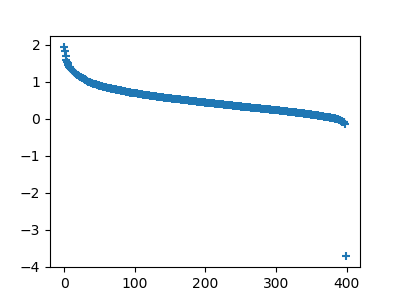

In [478]:
fig,ax = plt.subplots(1, figsize=[4,3])
ax.scatter(list(range(len(S))), np.log10(S), marker='+')

<IPython.core.display.Javascript object>


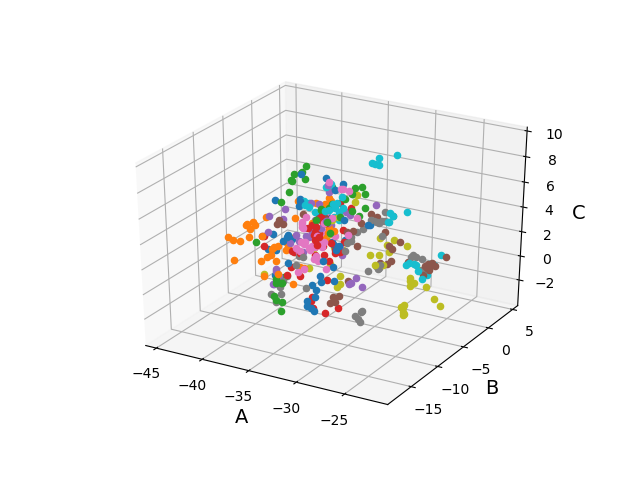

In [479]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
colors, cnorm = [mpl.cm.get_cmap('tab10'), np.max(Y)]
for i,j,k,c in zip(pcX[:,0], pcX[:,1], pcX[:,2],Y):
    ax.scatter(i,j,k,color=colors(c/cnorm))
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

## Agglomerative clustering using minimax

### Utilities

In [65]:
def construct_distance_matrix(X):
    '''
    Construct a distance matrix D={i,j, d(x_i,x_j): for all x_i, x_j in X}. 
        The matrix is symmetric so we just compute distances for all combinations 
        of len(X) choose 2. Use the lookup function 'lookup_distance' to get distances.
        Currently, Euclidean distance is the fixed behavior.
    
    Arguments:
        X: A list of elements from which to construct the distance matrix
    '''
    return [[i,j,np.sum(np.square(X[i]-X[j]))] for i,j in it.combinations(range(len(X)),2)]

Every index k < i contributes the full size of the set $n_k = \{j: k<j \text{ and } j < n\}$.
\begin{equation*}
    \sum_{k=0}^{i-1} (n-1)-i = i(n-1) - n(n-1)/2
\end{equation*}
The difference $j-i-1$ is how far along in the set $n_i$ to go to find the desired distance.

In [216]:
def lookup_distance(i, j, distance_matrix, n_elems, equal_distance = 0):
    '''
    Every index k < i contributes the full size of the set n_k = {j: k<j & j < n}.
        The total is \sum_{k=0}^{i-1} (n-1)-i = i(n-1) - n(n-1)/2
        The difference j-i-1 is how far along in the set n_i to 
        go to find the desired distance.
        
    Arguments:
        i: index of distance matrix
        j: other index of distance matrix
        distance_matrix: matrix of distances written [x1, x2, d(x1,x2)],\
                         follows the structure set in construct_distance_matrix
        n_elems: number of points in the initial set creating distance_matrix
        equal_distance: (Default 0) Distance of equivalent elements.
    '''
    if i==j:
        return equal_distance
    elif i < j:
        # Look up the correct row:
        return distance_matrix[i*(n_elems-1)-i*(i-1)//2 + j-i-1][2]
    else:
        return lookup_distance(j,i,distance_matrix,n_elems,equal_distance)

In [220]:
# Sloppy test cases:
test_distance = [[i,j,(i,j)] for i,j in it.combinations(range(9),2)]
print('(5,8)?', lookup_distance(5,8,test_distance,9), lookup_distance(8,5,test_distance, 9))
print('0?', lookup_distance(5,5,test_distance, 9))

(5,8)? (5, 8) (5, 8)
0? 0


In [402]:
def find_nearest_neighbor(index, distance_matrix, n_elems):
    '''
    Return the nearest neighbor of index from the set {0,1,2,...,n_elems-1}
        of possible_neighbors using distance defined in distance_matrix.
    '''
    possible_neighbors = list(range(n_elems))
    return min([[j,lookup_distance(index, j, distance_matrix, n_elems)] 
                for j in possible_neighbors if j != index],
               key=lambda x: x[1])[0]

In [384]:
def minimax_distance(G, H, distance, n_elems):
    G_union_H = G + H # list of original indices
    best_center = -1
    best_center_r = np.inf
    for center in G_union_H:
        center_max_r = max([lookup_distance(center, j, distance, n_elems)
                           for j in G_union_H if j != center])
        if center_max_r < best_center_r:
            best_center_r = center_max_r
            best_center = center
    return [best_center_r, best_center]

TODO: Update distance and update chain both should be refactored with a method called update index.

In [401]:
def update_distance(distance_matrix, rnn_pair):
    new_distance = []
    for d in distance:
        d0 = d[0]
        d1 = d[1]

        # Skip joined entries
        if d0 in rnn_pair:
            continue
        if d1 in rnn_pair:
            continue

        # Correct indices for removed entries
        if d[0] > rnn_pair[0]:
            d0 -= 1
        if d[0] > rnn_pair[1]:
            d0 -= 1
        if d[1] > rnn_pair[0]:
            d1 -= 1
        if d[1] > rnn_pair[1]:
            d1 -= 1

        # Increment to make room for new entries
        d0 += 1
        d1 += 1

        new_distance.append([d0,d1,d[2]])
    return new_distance

In [407]:
def update_chain(chain, rnn_pair):
    new_chain = []
    for c in chain:
        # Skip joined entries
        if c in rnn_pair:
            continue
            
        # Correct indices for removed entries          
        c_new = c
        if c > rnn_pair[0]:
            c_new -= 1
        if c > rnn_pair[1]:
            c_new -= 1
            
        # Increment to make room for new entries
        c_new += 1

        new_chain.append(c_new)
    return new_chain

### Algorithm

In [390]:
clustering = [[[i] for i in range(n)]] # iterations by list of sets

# Memory constraints might make pre-computing distances a problem (dismiss for now)
distance = construct_distance_matrix(X)
original_distances = distance

In [302]:
iteration = 0

# Chain can either contract to 0 or n-1 merges occur
chain = []

# Choose first entry of chain from available indices at the current iteration
chain.append(chain[0] if chain else np.random.choice(n-iteration))

In [303]:
# There are n-1-iteration neighbors available
for n_chainings in range(n-1-iteration):
    # Find the index of the closest entry
    neighbor = find_nearest_neighbor(chain[-1], distance, n-iteration)

    if len(chain) > 1 and chain[-2] == neighbor:
        print('RNN')
        break
    else:
        chain.append(neighbor)

RNN


In [377]:
G1 = clustering[iteration][chain[-1]]
G2 = clustering[iteration][chain[-2]]
clustering.append([G1 + G2] + [i for i in clustering[iteration] if i not in [G1, G2]])

iteration += 1

In [378]:
new_distance = []
for d in distance:
    d0 = d[0]
    d1 = d[1]
    
    # Skip removed entries
    if d0 in [chain[-1], chain[-2]]:
        continue
    if d1 in [chain[-1], chain[-2]]:
        continue
    
    # Correct indices for removed entries
    if d[0] > chain[-1]:
        d0 -= 1
    if d[0] > chain[-2]:
        d0 -= 1
    if d[1] > chain[-1]:
        d1 -= 1
    if d[1] > chain[-2]:
        d1 -= 1
    
    # Increment to make room for new entries
    d0 += 1
    d1 += 1
    
    new_distance.append([d0,d1,d[2]])

In [389]:
# Iterate over every entry and compute new cluster distances
new_distance_0 = [[0, i+1, minimax_distance(G1+G2, H, distance, n)[0]]
                  for i, H in enumerate(clustering[iteration][1:])]
new_distance = new_distance_0 + new_distance

### Put algorithm all-together now

The key idea of the implementation is that combinatorics outputs start with 0 and run over the entire range of other indices. The distance matrix will lose 2 indices on joining, but when those are deleted that corresponds to a simple reindexing of the space.

This does mean that all the other pieces in the game need reindexing, and that the clustering needs to match the new indices.

In [475]:
# Start with C_0 = {{x_1},{x_2},...,{x_n}} and d({x_i},{x_j})=d(x_i,x_j)
clustering = [[[i] for i in range(n)]] # List of clustering for each iteration
clustering_centers =  [[[i] for i in range(n)]]
distance = construct_distance_matrix(X)
original_distances = distance


# The chain is empty (the chain will count indices for C_{l-1})
chain = []
iteration = 0

# n-1 merges must occur (l counts merges)
for l in range(1, n):
    # 4. If chain is empty, choose an arbitrary index for C_{l-1};
    #    otherwise, let G be the current end of the chain.
    chain = chain if chain else [np.random.choice(n-iteration)]

    # 5. Grow a nearest neighbor chain from G until an RNN pair (G1,G2) is found
    # There are n-1-iteration neighbors searchable from chain[-1] (safer than while loop i.m.o)
    for growth in range(n-iteration-1):
        # Find the index of the closest entry
        neighbor = find_nearest_neighbor(chain[-1], distance, n-iteration)

        if len(chain) > 1 and chain[-2] == neighbor:
            break
        else:
            chain.append(neighbor)

    # Update the clustering by pre-pending the new pair
    G1 = clustering[iteration][chain[-1]]
    G2 = clustering[iteration][chain[-2]]
    new_clustering = []
    new_clustering_centers = []
    for group, center in zip(clustering[iteration], clustering_centers[iteration]):
        if group not in [G1, G2]:
            new_clustering.append(group)
            new_clustering_centers.append(center)
    
    clustering.append([G1 + G2] + new_clustering)
    clustering_centers.append([minimax_distance(G1, G2, original_distances, n)[1]] + new_clustering_centers)

    # Successfully created a new clustering, increment
    iteration += 1

    # Iterate over the new iteration clustering and compute the new cluster distances
    new_distance = [[0, i+1, minimax_distance(G1+G2, H, original_distances, n)[0]]
                      for i, H in enumerate(clustering[iteration][1:])]
    distance = new_distance + update_distance(distance, [chain[-1], chain[-2]])
    
    # Correct the indices in the chain
    chain = update_chain(chain, [chain[-1], chain[-2]])

# An example

<IPython.core.display.Javascript object>


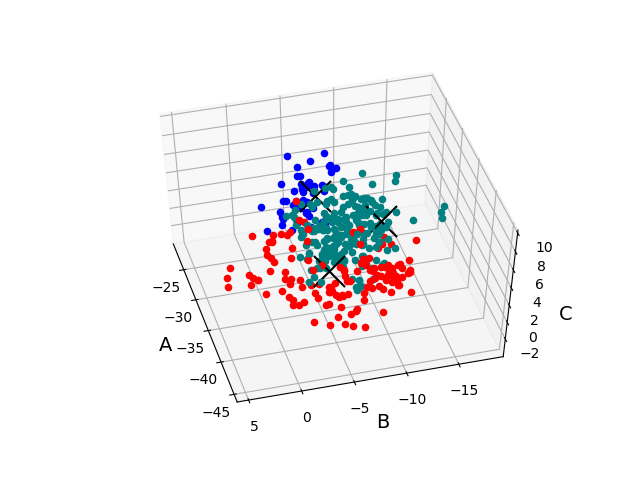

In [500]:
hclust = clustering[-3]
hclust_centers = clustering_centers[-3]

fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
for index, row in enumerate(pcX):
    i,j,k = row
    if index in hclust[0]:
        c='red'
    elif index in hclust[1]:
        c='blue'
    elif index in hclust[2]:
        c='teal'
    else:
        c='gray'
    
    if index in hclust_centers:
        ax.scatter(i,j,k,color='k', s=500, marker='x')
    else:
        ax.scatter(i,j,k,color=c)
    
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

<IPython.core.display.Javascript object>


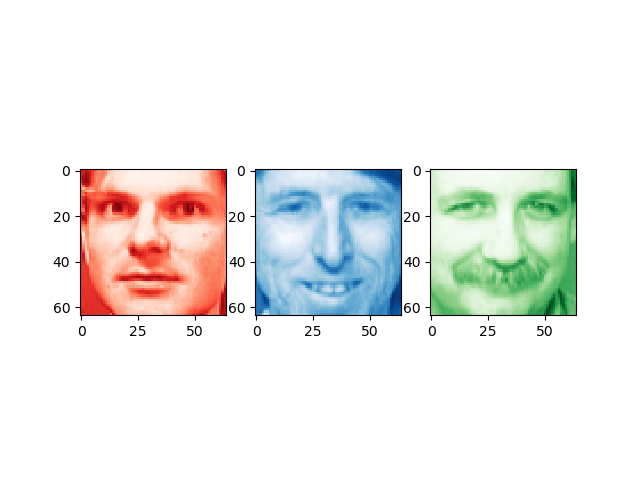

In [505]:
fig, ax = plt.subplots(1,len(hclust_centers))
for i,row in enumerate(hclust_centers):
    if row in hclust[0]:
        c='Reds'
    elif row in hclust[1]:
        c='Blues'
    elif row in hclust[2]:
        c='Greens'
    ax[i].imshow(1-X[row].reshape(64,64), cmap=c)
    

<IPython.core.display.Javascript object>


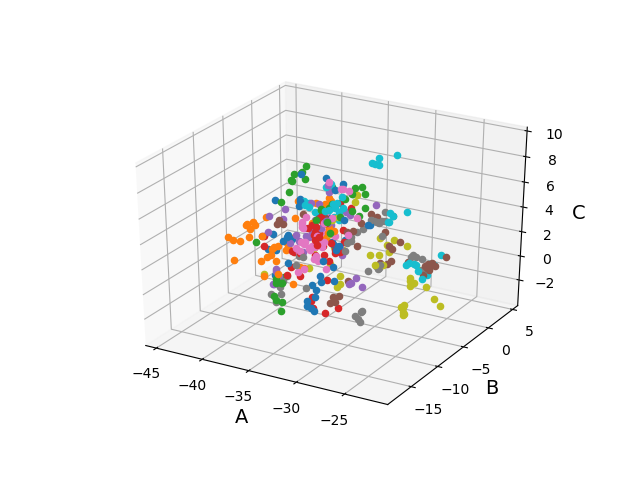

In [484]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
colors, cnorm = [mpl.cm.get_cmap('tab10'), np.max(Y)]
for i,j,k,c in zip(pcX[:,0], pcX[:,1], pcX[:,2],Y):
    ax.scatter(i,j,k,color=colors(c/cnorm))
labelXYZ(ax, 'A','B','C', {'fontsize': 14});